In [109]:
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import re
import requests
import os
import textwrap

In [110]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}
random.shuffle(letters2)

for k, v in zip(letters1, letters2):
  true_mapping[k] = v

In [111]:
M = np.ones((26, 26))
pi = np.zeros(26)

def update_transition(ch1, ch2):
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

def get_word_prob(word):
  i = ord(word[0]) - 97
  logp = np.log(pi[i])
  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j])
    i = j
  return logp

def get_sequence_prob(words):
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)

  return logp

In [112]:
if not os.path.exists('moby_dick.txt'):
  print('Downloading Moby Dick...')
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

regex = re.compile('[^a-zA-Z]')

for line in open('moby_dick.txt'):
  line = line.rstrip()
  if line:
    line = regex.sub(' ', line)
    tokens = line.lower().split()
    for token in tokens:
      ch0 = token[0]
      update_pi(ch0)

      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [113]:
original_message = 'I then lounged down the street and found, as I expected, that there was a mews in a lane which runs down by one wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence, a glass of half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler, to say nothing of half a dozen other people in the neighbourhood in whom I was not in the least interested, but whose biographies I was compelled to listen to.'

In [114]:
def encode_message(msg):
  msg = msg.lower()
  msg = regex.sub(' ', msg)
  cipher = []
  for ch in msg:
    coded_ch = ch
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    cipher.append(coded_ch)
    
  return ''.join(cipher)

In [115]:
cipher = encode_message(original_message)

In [116]:
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)
  return ''.join(decoded_msg)

In [117]:
dna_pool = []
for _ in range(100):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [118]:
def evolve_offspring(dna_pool, n_children):
  offspring = []
  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))
      # swap
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)
  return offspring + dna_pool

In [119]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
  if i > 0:
    dna_pool = evolve_offspring(dna_pool, 3)
  
  dna2score = {}
  for dna in dna_pool:
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v
    
    decoded_message = decode_message(cipher, current_map)
    score = get_sequence_prob(decoded_message)
    dna2score[''.join(dna)] = score

    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score
    
  scores[i] = np.mean(list(dna2score.values()))

  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]
  if i % 200 == 0:
    print("iter:", i, "score", scores[i], "best so far:", best_score)




iter: 0 score -2116.8024874655553 best so far: -1680.459442103984
iter: 200 score -1067.8450257598345 best so far: -995.8392605847695
iter: 400 score -1020.0875029758403 best so far: -929.5902922650557
iter: 600 score -1056.6840127960209 best so far: -929.5902922650557
iter: 800 score -1038.4381483293066 best so far: -929.5902922650557


In [121]:
decoded_message = decode_message(cipher, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))


LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: k, pred: q
true: q, pred: z
true: z, pred: k


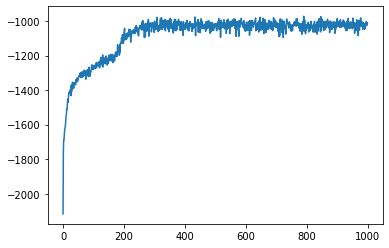

In [122]:
plt.plot(scores)
plt.show()